In [1]:
%%capture
import sys
!pip install tensorflow-addons
!pip install yfinance
!git clone https://github.com/ICascha/QuantGANs-replication.git
sys.path.append('/content/QuantGANs-replication/')

In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import GAN
from backend.tcn import make_TCN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()

from scipy.stats import norm, pearsonr
from tensorflow.random import normal
from google.colab import files

In [3]:
df = pdr.get_data_yahoo(['AAPL', 'MSFT'], start="2014-1-1", end="2018-12-31")['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy()

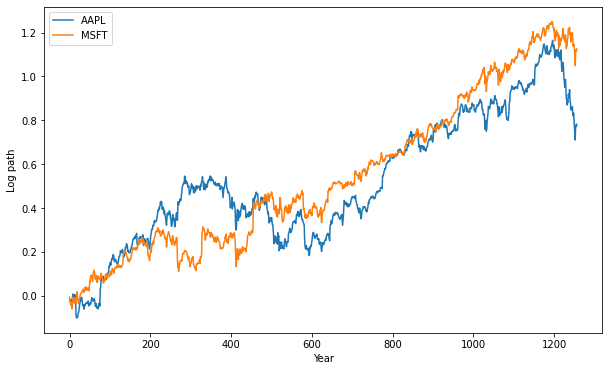

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(log_returns.cumsum(axis=0));
ax.legend(df.columns)
ax.set_xlabel('Year')
ax.set_ylabel('Log path');

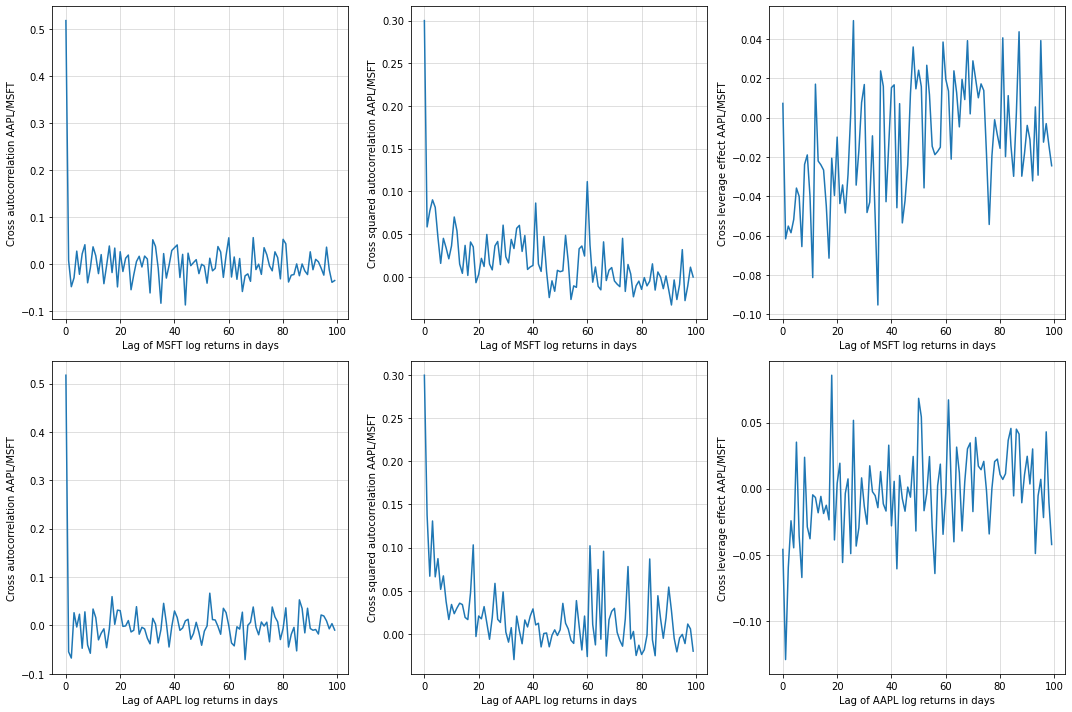

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

axs[0, 0].set_xlabel('Lag of MSFT log returns in days')
axs[0, 0].set_ylabel('Cross autocorrelation AAPL/MSFT')
axs[0, 0].plot(cross_acf(log_returns[:, [0]], log_returns[:, [1]], 100))

axs[1, 0].set_xlabel('Lag of AAPL log returns in days')
axs[1, 0].set_ylabel('Cross autocorrelation AAPL/MSFT')
axs[1, 0].plot(cross_acf(log_returns[:, [1]], log_returns[:, [0]], 100))

axs[0, 1].set_xlabel('Lag of MSFT log returns in days')
axs[0, 1].set_ylabel('Cross squared autocorrelation AAPL/MSFT')
axs[0, 1].plot(cross_acf(log_returns[:, [0]]**2, log_returns[:, [1]]**2, 100))

axs[1, 1].set_xlabel('Lag of AAPL log returns in days')
axs[1, 1].set_ylabel('Cross squared autocorrelation AAPL/MSFT')
axs[1, 1].plot(cross_acf(log_returns[:, [1]]**2, log_returns[:, [0]]**2, 100))

axs[0, 2].set_xlabel('Lag of MSFT log returns in days')
axs[0, 2].set_ylabel('Cross leverage effect AAPL/MSFT')
axs[0, 2].plot(cross_acf(log_returns[:, [0]], log_returns[:, [1]]**2, 100))

axs[1, 2].set_xlabel('Lag of AAPL log returns in days')
axs[1, 2].set_ylabel('Cross leverage effect AAPL/MSFT')
axs[1, 2].plot(cross_acf(log_returns[:, [1]], log_returns[:, [0]]**2, 100))

for ax in axs.ravel(): 
    ax.grid(True, alpha=0.5)
    ax.set_axisbelow(True)

fig.tight_layout();

In [6]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

In [7]:
dilations = 2**(np.arange(6))
n_filters = 40

discriminator = make_TCN(dilations, n_filters, 0, False, True, True, [2, rfs, 1])
generator = make_TCN(dilations, n_filters, 0, True, False, False, [2, None, 3])

In [8]:
class verboseGAN(GAN):
    def train_hook(self, n_batch):
        if (n_batch + 1) % 50 == 0:
            y = self.generator(self.fixed_noise).numpy().squeeze()

            scores = []
            scores.append(np.linalg.norm(self.cacf_real_msft - cross_acf(y[:, 0].T, y[:, 1].T, 100).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.cacf_real_aapl - cross_acf(y[:, 1].T, y[:, 0].T, 100).mean(axis=1, keepdims=True)))
            print("\ncross_acf_msft: {:.4f}, cross_acf_aapl: {:.4f}".format(*scores))
        
gan = verboseGAN(discriminator, generator, lr_d=1e-4, lr_g=3e-5)

gan.cacf_real_msft = cross_acf(log_returns_preprocessed[:, [0]], log_returns_preprocessed[:, [1]], 100)
gan.cacf_real_aapl = cross_acf(log_returns_preprocessed[:, [1]], log_returns_preprocessed[:, [0]], 100)

gan.fixed_noise = normal([128, 2, 4000 + rfs - 1, 3])

In [9]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0, 2), -1)
batch_size = 64
n_batches = 5000
additional_d_steps = 0

gan.train(data, batch_size, n_batches, additional_d_steps)

  49/5000 [..............................] - ETA: 32:58
cross_acf_msft: 0.5753, cross_acf_aapl: 0.5799
  99/5000 [..............................] - ETA: 38:02
cross_acf_msft: 0.5537, cross_acf_aapl: 0.5541
 149/5000 [..............................] - ETA: 37:55
cross_acf_msft: 0.3576, cross_acf_aapl: 0.3978
 199/5000 [>.............................] - ETA: 37:39
cross_acf_msft: 0.3141, cross_acf_aapl: 0.3654
 249/5000 [>.............................] - ETA: 37:19
cross_acf_msft: 0.3493, cross_acf_aapl: 0.3784
 299/5000 [>.............................] - ETA: 36:58
cross_acf_msft: 0.3547, cross_acf_aapl: 0.3540
 349/5000 [=>............................] - ETA: 36:37
cross_acf_msft: 0.3428, cross_acf_aapl: 0.3285
 399/5000 [=>............................] - ETA: 36:15
cross_acf_msft: 0.3299, cross_acf_aapl: 0.3229
 449/5000 [=>............................] - ETA: 35:53
cross_acf_msft: 0.3810, cross_acf_aapl: 0.3748
 499/5000 [=>............................] - ETA: 35:30
cross_acf_msft: 0

In [10]:
%%capture
generator.save('trained_generator_aapl_msft')
!zip -r trained_generator_aapl_msft.zip trained_generator_aapl_msft/ 

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/THESIS/trained_generator_aapl_msft/assets


In [11]:
files.download('trained_generator_aapl_msft.zip')

In [12]:
# Filter out paths with a maximum/minimum return filter_constant times that of 
# the maximum/minimum return of the original distribution
filter_constant = 2
n_samples = 1000
length = len(log_returns)

noise = normal([n_samples, 2, length + rfs - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean())/y.std()
y = s2.inverse_transform(np.moveaxis(y, 0, 2).T)
y = g1.inverse_transform(np.expand_dims(y.flatten(), 1)).reshape(n_samples, length, 2)
y = s1.inverse_transform(y)
y = y[(y.max(axis=(1, 2)) <= filter_constant * log_returns.max()) & (y.max(axis=(1, 2)) >= filter_constant * log_returns.min())]

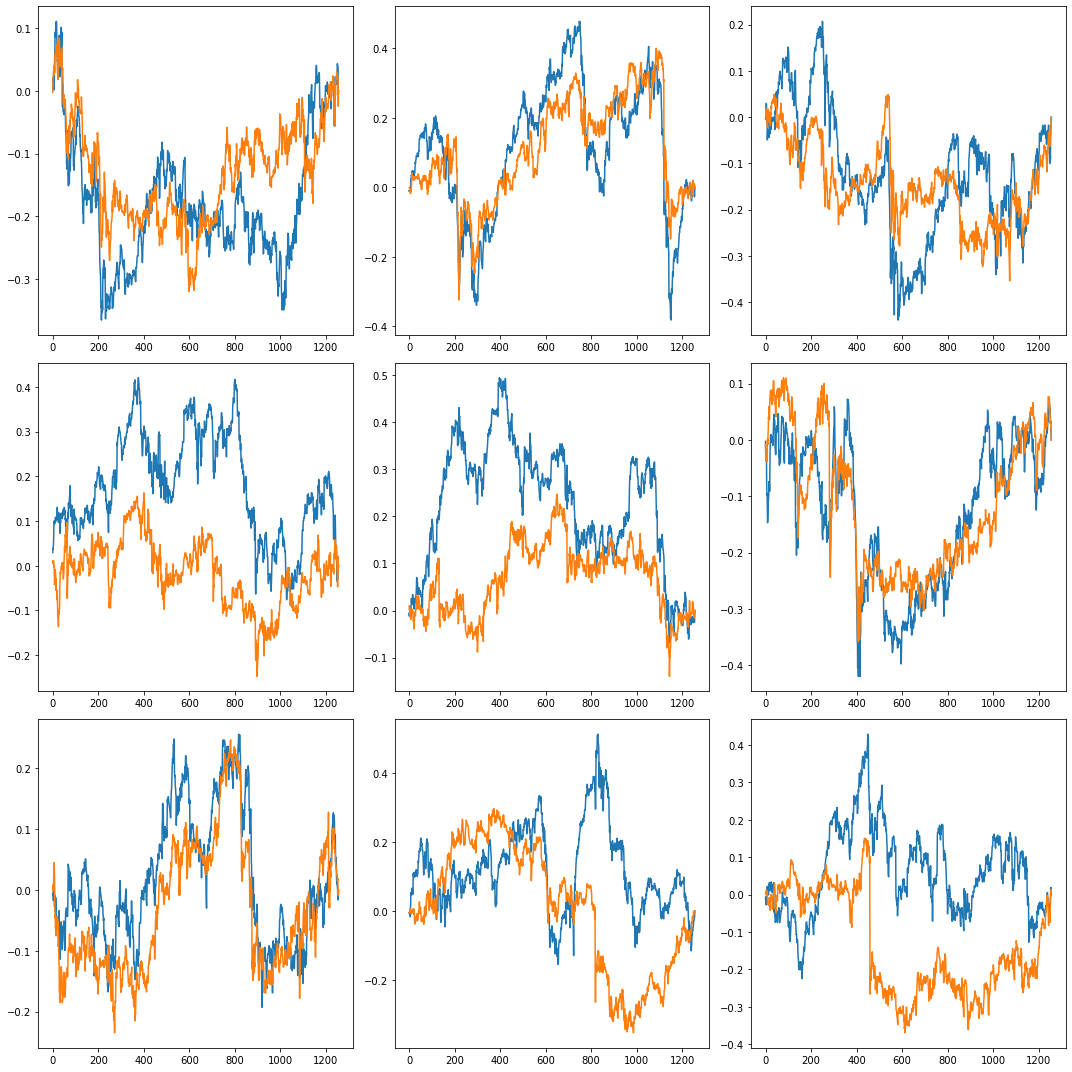

In [13]:
# Some centered logpaths

fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)

i = 0

for ax in axs.ravel():
    ax.plot((y[i] - y[i].mean(axis=0)).cumsum(axis=0))
    i += 1
    if i == 9:
        break

fig.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

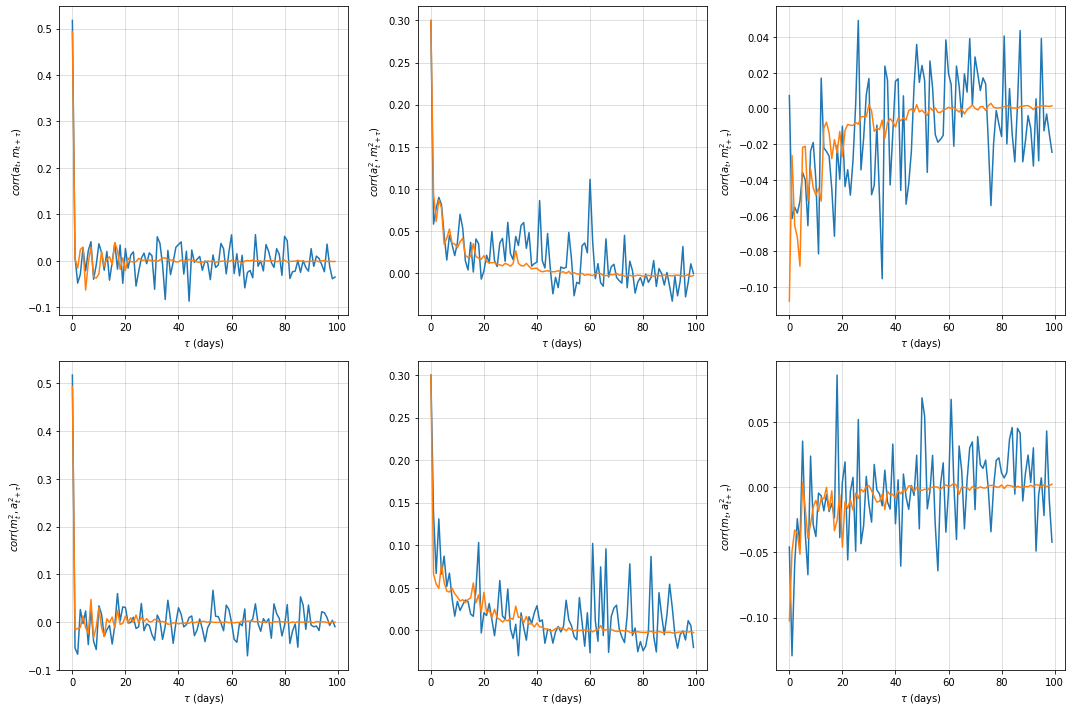

In [14]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

axs[0, 0].set_ylabel('$corr(a_t, m_{t+\\tau})$')
axs[0, 0].plot(cross_acf(log_returns[:, [0]], log_returns[:, [1]], 100))
axs[0, 0].plot(cross_acf(y[:, :, 0].T, y[:, :, 1].T, 100).mean(axis=1))

axs[1, 0].set_ylabel('$corr(m_t, a_{t+\\tau})$')
axs[1, 0].plot(cross_acf(log_returns[:, [1]], log_returns[:, [0]], 100))
axs[1, 0].plot(cross_acf(y[:, :, 1].T, y[:, :, 0].T, 100).mean(axis=1))

axs[0, 1].set_ylabel('$corr(a_t^2, m_{t+\\tau}^2)$')
axs[0, 1].plot(cross_acf(log_returns[:, [0]]**2, log_returns[:, [1]]**2, 100))
axs[0, 1].plot(cross_acf(y[:, :, 0].T**2, y[:, :, 1].T**2, 100).mean(axis=1))

axs[1, 0].set_ylabel('$corr(m_t^2, a_{t+\\tau}^2)$')
axs[1, 1].plot(cross_acf(log_returns[:, [1]]**2, log_returns[:, [0]]**2, 100))
axs[1, 1].plot(cross_acf(y[:, :, 1].T**2, y[:, :, 0].T**2, 100).mean(axis=1))

axs[0, 2].set_ylabel('$corr(a_t, m_{t+\\tau}^2)$')
axs[0, 2].plot(cross_acf(log_returns[:, [0]], log_returns[:, [1]]**2, 100))
axs[0, 2].plot(cross_acf(y[:, :, 0].T, y[:, :, 1].T**2, 100).mean(axis=1))

axs[1, 2].set_ylabel('$corr(m_t, a_{t+\\tau}^2)$')
axs[1, 2].plot(cross_acf(log_returns[:, [1]], log_returns[:, [0]]**2, 100))
axs[1, 2].plot(cross_acf(y[:, :, 1].T, y[:, :, 0].T**2, 100).mean(axis=1))

for ax in axs.ravel(): 
    ax.grid(True, alpha=0.5)
    ax.set_axisbelow(True)
    plt.setp(axs, xlabel='$\\tau$ (days)')

fig.tight_layout();

plt.savefig('cross_dependency.png', dpi=300)
files.download('cross_dependency.png')